#Step 1: Import Libraries

In [ ]:
pip install -U scikit-learn==0.24.2

Requirement already up-to-date: scikit-learn==0.24.2 in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [1]:
%tensorflow_version 2.x
from numpy.random import seed
seed(2)
#from tensorflow import set_random_seed
#set_random_seed(2)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.python.data import Dataset
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.losses import sparse_categorical_crossentropy
from sklearn.preprocessing import LabelBinarizer
print(tf.__version__)

2.5.0


# Step 2: Import Data

In [2]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.2f}'.format

liver_data = pd.read_csv("LiverData.csv", sep=",")
liver_data = liver_data.reindex(np.random.permutation(liver_data.index))
liver_data.head()

,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,WBC,RBC,HGB,Plat,AST 1,ALT 1,ALT4,ALT 12,ALT 24,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Class
930,39,Male,28,Present,Present,Absent,Absent,Present,Absent,Absent,4853,3900189,12,106850,99,89,123,110,108,67,58,33,1019551,332115,5,5,5,Cirrhosis
199,54,Female,29,Present,Absent,Present,Present,Absent,Absent,Present,5994,4044419,12,217018,112,115,119,123,106,119,97,34,1190662,14287,556670,771412,100993,Portal Fibrosis
1359,35,Male,23,Present,Absent,Present,Absent,Absent,Absent,Present,10747,4697095,12,215271,49,70,59,57,106,74,75,28,327488,563281,745665,348266,605628,Portal Fibrosis
861,55,Female,33,Present,Absent,Absent,Absent,Present,Absent,Absent,7658,4458604,10,140534,107,86,56,73,69,113,50,45,55781,145136,5,5,5,Many Septa
387,40,Female,32,Absent,Present,Absent,Absent,Present,Absent,Present,7723,4860218,14,108195,62,124,57,118,115,46,53,25,30004,58435,5,5,5,Few Septa


In [3]:
liver_data.columns

Index(['Age ', 'Gender', 'BMI', 'Fever', 'Nausea/Vomting', 'Headache ',
       'Diarrhea ', 'Fatigue & generalized bone ache ', 'Jaundice ',
       'Epigastric pain ', 'WBC', 'RBC', 'HGB', 'Plat', 'AST 1', 'ALT 1',
       'ALT4', 'ALT 12', 'ALT 24', 'ALT 36', 'ALT 48', 'ALT after 24 w',
       'RNA Base', 'RNA 4', 'RNA 12', 'RNA EOT', 'RNA EF', 'Class'],
      dtype='object')

In [4]:
liver_data = liver_data.loc[:,['Age ', 'Gender', 'BMI', 'Fever', 'Nausea/Vomting', 'Headache ',
       'Diarrhea ', 'Fatigue & generalized bone ache ', 'Jaundice ',
       'Epigastric pain ', 'WBC', 'RBC', 'HGB', 'Plat', 'AST 1', 'ALT 1','RNA Base','Class']]

# Step 3: EDA - Exploratory Data Analysis
*   Checking the baseline/target variable distribution in raw data
*   Analyzing "target variable" across other variables
*   Checking for missing values

Cirrhosis         0.26
Many Septa        0.26
Portal Fibrosis   0.24
Few Septa         0.24
Name: Class, dtype: float64 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


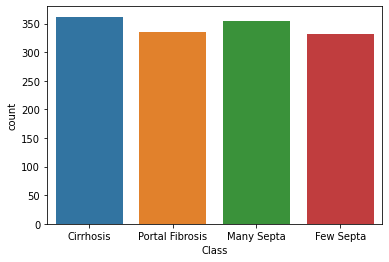

In [5]:
#Distribution of "Class"
print(round(liver_data['Class'].value_counts()/len(liver_data),2),"\n")
sns.countplot('Class',data = liver_data);

#thus the baseline for the prediction model is 26%

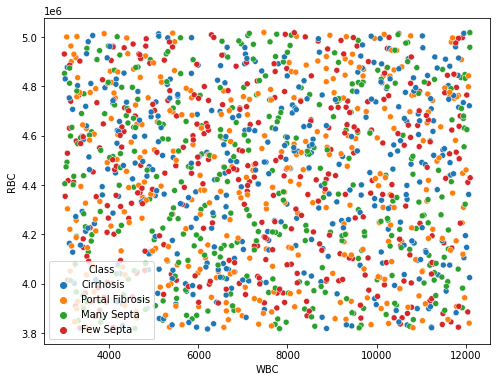

In [11]:
# Scatter plot of WBC and RBC across "liver disease"
figure(figsize=(8, 6))
sns.scatterplot(data=liver_data, x="WBC", y="RBC", hue="Class")

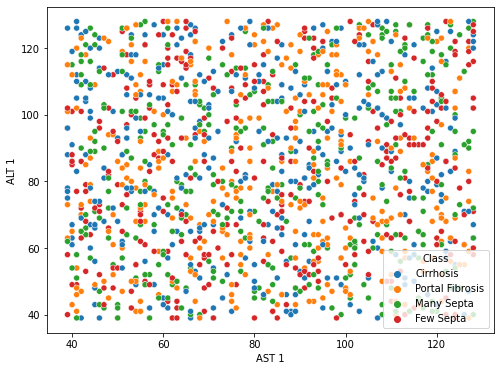

In [12]:
# Scatter plot of AST and ALT across "liver disease"
figure(figsize=(8, 6))
sns.scatterplot(data=liver_data, x="AST 1", y="ALT 1", hue="Class")

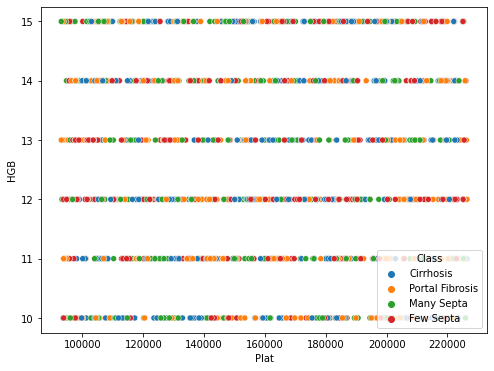

In [13]:
# Scatter plot of Plat and HGB across "liver disease"
figure(figsize=(8, 6))
sns.scatterplot(data=liver_data, x="Plat", y="HGB", hue="Class")

In [15]:
#Checking for "NA/NULL" values
liver_data.isna().sum()

Age               0
Gender            0
BMI               0
Fever             0
Nausea/Vomting    0
                 ..
Plat              0
AST 1             0
ALT 1             0
RNA Base          0
Class             0
Length: 18, dtype: int64

#Step 4: Data Preprocess for Model
*   Considering all the attributes in the data to build the model as all of those attributes seems relevant for prediction of typpe of liver disease 

## Creating a function to segregate numeric and categorical features into two different dataframes

In [16]:
def segregate_numeric_categorical_features(df):
  df = df.drop('Class',axis=1)
  cols = df.columns
  df_num = pd.DataFrame()
  df_cat = pd.DataFrame()
  for each in cols:
    if df[each].dtypes == 'int64':
      df_num[each] = df[each]
    else:
      df_cat[each] = df[each]
  return (df_num,df_cat)

## Segregating data
### Steps followed:
1.   Segregating data into two dataframes having only numeric and categorical attributes
2. One hot encoding for catergorical variables
3. Label encoding for class variable
4. Combining the data back into one dataframe

In [17]:
liver_data_num,liver_data_cat = segregate_numeric_categorical_features(liver_data)

#one-hot encoding
liver_data_cat_enc = pd.get_dummies(liver_data_cat, columns=liver_data_cat.columns)

#label (target variable) encoder for class variable
encoder = LabelBinarizer()
label = encoder.fit_transform(liver_data["Class"])

#Combining the data
liver_data_final = pd.concat([liver_data_cat_enc,liver_data_num], axis=1)

In [18]:
label

array([[1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

In [19]:
liver_data_final.head()

,Gender_Female,Gender_Male,Fever_Absent,Fever_Present,Nausea/Vomting_Absent,Nausea/Vomting_Present,Headache _Absent,Headache _Present,Diarrhea _Absent,Diarrhea _Present,Fatigue & generalized bone ache _Absent,Fatigue & generalized bone ache _Present,Jaundice _Absent,Jaundice _Present,Epigastric pain _Absent,Epigastric pain _Present,Age,BMI,WBC,RBC,HGB,Plat,AST 1,ALT 1,RNA Base
930,0,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,39,28,4853,3900189,12,106850,99,89,1019551
199,1,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,54,29,5994,4044419,12,217018,112,115,1190662
1359,0,1,0,1,1,0,0,1,1,0,1,0,1,0,0,1,35,23,10747,4697095,12,215271,49,70,327488
861,1,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,55,33,7658,4458604,10,140534,107,86,55781
387,1,0,1,0,0,1,1,0,1,0,0,1,1,0,0,1,40,32,7723,4860218,14,108195,62,124,30004


## Training data processing

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [21]:
# Selecting first 90% examples for training.
training_examples, validation_examples, training_targets, validation_targets = train_test_split(liver_data_final, label, test_size=0.1, random_state=101)

#Scaling training data 
scaler = StandardScaler().fit(training_examples.values)
scaledf = scaler.transform(training_examples.values)
training_examples = pd.DataFrame(scaledf, index=training_examples.index, columns=training_examples.columns)

# Cross-check the prepared data
print("Training examples summary:")
display.display(training_examples.describe())


Training examples summary:


,Gender_Female,Gender_Male,Fever_Absent,Fever_Present,Nausea/Vomting_Absent,Nausea/Vomting_Present,Headache _Absent,Headache _Present,Diarrhea _Absent,Diarrhea _Present,Fatigue & generalized bone ache _Absent,Fatigue & generalized bone ache _Present,Jaundice _Absent,Jaundice _Present,Epigastric pain _Absent,Epigastric pain _Present,Age,BMI,WBC,RBC,HGB,Plat,AST 1,ALT 1,RNA Base
count,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00,1246.00
mean,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.98,-1.02,-0.97,-1.03,-0.99,-1.01,-1.01,-0.99,-0.98,-1.02,-0.98,-1.02,-1.01,-0.99,-1.00,-1.00,-1.63,-1.61,-1.70,-1.74,-1.51,-1.69,-1.69,-1.73,-1.67
25%,-0.98,-1.02,-0.97,-1.03,-0.99,-1.01,-1.01,-0.99,-0.98,-1.02,-0.98,-1.02,-1.01,-0.99,-1.00,-1.00,-0.84,-0.88,-0.87,-0.86,-0.93,-0.86,-0.88,-0.85,-0.91
50%,-0.98,0.98,-0.97,0.97,-0.99,0.99,0.99,-0.99,-0.98,0.98,-0.98,0.98,0.99,-0.99,-1.00,1.00,0.07,0.10,-0.03,0.03,0.24,-0.01,0.00,0.00,0.01
75%,1.02,0.98,1.03,0.97,1.01,0.99,0.99,1.01,1.02,0.98,1.02,0.98,0.99,1.01,1.00,1.00,0.86,0.83,0.91,0.85,0.82,0.82,0.89,0.85,0.84
max,1.02,0.98,1.03,0.97,1.01,0.99,0.99,1.01,1.02,0.98,1.02,0.98,0.99,1.01,1.00,1.00,1.65,1.57,1.71,1.73,1.40,1.76,1.73,1.70,1.72


In [22]:
#"Class" in training data
training_targets

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

## Validation data processing

In [23]:
#Scaling validation data 
vscaled = scaler.transform(validation_examples.values)
validation_examples = pd.DataFrame(vscaled, index=validation_examples.index, columns=validation_examples.columns)

print("Validation examples summary:")
display.display(validation_examples.describe())

Validation examples summary:


,Gender_Female,Gender_Male,Fever_Absent,Fever_Present,Nausea/Vomting_Absent,Nausea/Vomting_Present,Headache _Absent,Headache _Present,Diarrhea _Absent,Diarrhea _Present,Fatigue & generalized bone ache _Absent,Fatigue & generalized bone ache _Present,Jaundice _Absent,Jaundice _Present,Epigastric pain _Absent,Epigastric pain _Present,Age,BMI,WBC,RBC,HGB,Plat,AST 1,ALT 1,RNA Base
count,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00,139.00
mean,-0.02,0.02,0.03,-0.03,0.05,-0.05,-0.02,0.02,0.11,-0.11,0.21,-0.21,-0.10,0.10,-0.03,0.03,-0.11,0.04,-0.03,0.07,-0.04,-0.02,-0.07,-0.01,-0.03
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,0.98,1.00,1.00,1.00,1.00,0.95,0.97,0.98,1.00,1.00,1.01,0.99,0.99,1.00
min,-0.98,-1.02,-0.97,-1.03,-0.99,-1.01,-1.01,-0.99,-0.98,-1.02,-0.98,-1.02,-1.01,-0.99,-1.00,-1.00,-1.63,-1.61,-1.66,-1.74,-1.51,-1.65,-1.69,-1.73,-1.66
25%,-0.98,-1.02,-0.97,-1.03,-0.99,-1.01,-1.01,-0.99,-0.98,-1.02,-0.98,-1.02,-1.01,-0.99,-1.00,-1.00,-0.84,-0.88,-0.89,-0.81,-0.93,-0.94,-0.84,-0.79,-1.00
50%,-0.98,0.98,-0.97,0.97,1.01,-1.01,-1.01,1.01,1.02,-1.02,1.02,-1.02,-1.01,1.01,-1.00,1.00,-0.27,0.10,0.04,0.20,0.24,-0.06,-0.11,-0.11,-0.00
75%,1.02,0.98,1.03,0.97,1.01,0.99,0.99,1.01,1.02,0.98,1.02,0.98,0.99,1.01,1.00,1.00,0.75,0.83,0.76,0.93,0.82,0.89,0.79,0.89,0.80
max,1.02,0.98,1.03,0.97,1.01,0.99,0.99,1.01,1.02,0.98,1.02,0.98,0.99,1.01,1.00,1.00,1.65,1.57,1.70,1.68,1.40,1.75,1.69,1.70,1.69


#Step 5: Model Building, Evaluation and Result Plots

## Model

In [24]:
#Checking number of columns in the training sample
training_examples.shape

(1246, 25)

### Model-1

In [25]:
#Building model with hidden layers
model1 = keras.Sequential([
    keras.layers.Dense(25, activation=tf.nn.relu,
                       input_shape=(training_examples.shape[1],)),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(12, activation=tf.nn.relu,),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(6, activation=tf.nn.relu,),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(4, activation=tf.nn.softmax,)

  ])

model1.compile(loss='categorical_crossentropy',
                optimizer="adam",
                metrics=['accuracy'])

keras.optimizers.Adam(learning_rate=0.006, beta_1=0.9, beta_2=0.999, amsgrad=False)
#beta_1 : A float value or a constant float tensor. The exponential decay rate for the 1st moment estimates. 
#beta_2 : A float value or a constant float tensor. The exponential decay rate for the 2nd moment estimates.
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                650       
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                312       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2

In [26]:
#Fit Model-1
EPOCHS = 60

early_stopping = EarlyStopping(monitor='val_loss',patience=10)
model1_history = model1.fit(training_examples, training_targets, epochs=EPOCHS,
                    validation_data= (validation_examples, validation_targets)
                    ,callbacks=[early_stopping])

Epoch 1/60
39/39 [==============================] - 1s 12ms/step - loss: 1.4305 - accuracy: 0.2785 - val_loss: 1.4159 - val_accuracy: 0.2446
Epoch 2/60
39/39 [==============================] - 0s 3ms/step - loss: 1.4108 - accuracy: 0.2584 - val_loss: 1.4055 - val_accuracy: 0.2302
Epoch 3/60
39/39 [==============================] - 0s 3ms/step - loss: 1.4026 - accuracy: 0.2384 - val_loss: 1.3961 - val_accuracy: 0.2302
Epoch 4/60
39/39 [==============================] - 0s 2ms/step - loss: 1.3876 - accuracy: 0.2624 - val_loss: 1.3946 - val_accuracy: 0.2230
Epoch 5/60
39/39 [==============================] - 0s 2ms/step - loss: 1.3870 - accuracy: 0.2552 - val_loss: 1.3909 - val_accuracy: 0.2374
Epoch 6/60
39/39 [==============================] - 0s 2ms/step - loss: 1.3797 - accuracy: 0.2881 - val_loss: 1.3906 - val_accuracy: 0.2302
Epoch 7/60
39/39 [==============================] - 0s 3ms/step - loss: 1.3878 - accuracy: 0.2624 - val_loss: 1.3906 - val_accuracy: 0.2374
Epoch 8/60
39/39 [=

### Model-2

In [27]:
#Building model with hidden layers
model2 = keras.Sequential([
    keras.layers.Dense(25, activation=tf.nn.relu,
                       input_shape=(training_examples.shape[1],),),
    keras.layers.Dense(12, activation=tf.nn.relu,),
    keras.layers.Dense(4, activation=tf.nn.softmax,)
  ])
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy']) 

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                312       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 52        
Total params: 1,014
Trainable params: 1,014
Non-trainable params: 0
_________________________________________________________________


In [28]:
#Fit Model-2
EPOCHS = 60

early_stopping = EarlyStopping(monitor='val_accuracy',patience=10)
model2_history = model2.fit(training_examples, training_targets, epochs=EPOCHS,
                    validation_data= (validation_examples, validation_targets)
                    ,callbacks=[early_stopping])

Epoch 1/60
39/39 [==============================] - 1s 7ms/step - loss: 1.4856 - accuracy: 0.2271 - val_loss: 1.4514 - val_accuracy: 0.2518
Epoch 2/60
39/39 [==============================] - 0s 2ms/step - loss: 1.4177 - accuracy: 0.2464 - val_loss: 1.4335 - val_accuracy: 0.2734
Epoch 3/60
39/39 [==============================] - 0s 2ms/step - loss: 1.3985 - accuracy: 0.2568 - val_loss: 1.4224 - val_accuracy: 0.2806
Epoch 4/60
39/39 [==============================] - 0s 3ms/step - loss: 1.3878 - accuracy: 0.2705 - val_loss: 1.4152 - val_accuracy: 0.2806
Epoch 5/60
39/39 [==============================] - 0s 2ms/step - loss: 1.3803 - accuracy: 0.2921 - val_loss: 1.4114 - val_accuracy: 0.2950
Epoch 6/60
39/39 [==============================] - 0s 2ms/step - loss: 1.3736 - accuracy: 0.2937 - val_loss: 1.4104 - val_accuracy: 0.3022
Epoch 7/60
39/39 [==============================] - 0s 3ms/step - loss: 1.3691 - accuracy: 0.3018 - val_loss: 1.4085 - val_accuracy: 0.3022
Epoch 8/60
39/39 [==

### Model-3

In [29]:
#Building model with hidden layers
model3 = keras.Sequential([
    keras.layers.Dense(25, activation=tf.nn.relu,
                       input_shape=(training_examples.shape[1],),),
    keras.layers.Dense(4, activation=tf.nn.softmax,)
  ])
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy']) 

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 104       
Total params: 754
Trainable params: 754
Non-trainable params: 0
_________________________________________________________________


In [30]:
#Fit Model-3
EPOCHS = 60

early_stopping = EarlyStopping(monitor='val_accuracy',patience=10)
model3_history = model3.fit(training_examples, training_targets, epochs=EPOCHS,
                    validation_data= (validation_examples, validation_targets)
                    ,callbacks=[early_stopping])

Epoch 1/60
39/39 [==============================] - 1s 6ms/step - loss: 1.5017 - accuracy: 0.2665 - val_loss: 1.4924 - val_accuracy: 0.2374
Epoch 2/60
39/39 [==============================] - 0s 2ms/step - loss: 1.4424 - accuracy: 0.2849 - val_loss: 1.4635 - val_accuracy: 0.2446
Epoch 3/60
39/39 [==============================] - 0s 2ms/step - loss: 1.4110 - accuracy: 0.2873 - val_loss: 1.4489 - val_accuracy: 0.2590
Epoch 4/60
39/39 [==============================] - 0s 2ms/step - loss: 1.3922 - accuracy: 0.3018 - val_loss: 1.4404 - val_accuracy: 0.2518
Epoch 5/60
39/39 [==============================] - 0s 2ms/step - loss: 1.3781 - accuracy: 0.3122 - val_loss: 1.4368 - val_accuracy: 0.2806
Epoch 6/60
39/39 [==============================] - 0s 3ms/step - loss: 1.3688 - accuracy: 0.3194 - val_loss: 1.4322 - val_accuracy: 0.2806
Epoch 7/60
39/39 [==============================] - 0s 2ms/step - loss: 1.3604 - accuracy: 0.3291 - val_loss: 1.4327 - val_accuracy: 0.3022
Epoch 8/60
39/39 [==

## Evaluation

In [31]:
#Minimum and Maximum Loss of model 1
print("Min Loss of model:",min(model1_history.history['val_loss']))
print("Max Loss of model:",max(model1_history.history['val_loss']))

Min Loss of model: 1.3862807750701904
Max Loss of model: 1.4159362316131592


In [32]:
#Minimum and Maximum Loss of model 2
print("Min Loss of model:",min(model2_history.history['val_loss']))
print("Max Loss of model:",max(model2_history.history['val_loss']))

Min Loss of model: 1.402215838432312
Max Loss of model: 1.451430320739746


In [33]:
#Minimum and Maximum Loss of model 3
print("Min Loss of model:",min(model3_history.history['val_loss']))
print("Max Loss of model:",max(model3_history.history['val_loss']))

Min Loss of model: 1.427169680595398
Max Loss of model: 1.4924111366271973


## Plotting the errors of model




In [34]:
losses1 = pd.DataFrame(model1_history.history)
losses2 = pd.DataFrame(model2_history.history)
losses3 = pd.DataFrame(model3_history.history)

<Figure size 720x720 with 0 Axes>

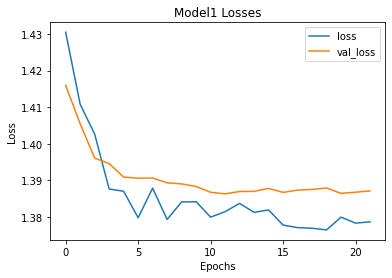

In [35]:
plt.figure(figsize=(10, 10))
losses1[['loss','val_loss']].plot()
plt.title('Model1 Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss');

<Figure size 720x720 with 0 Axes>

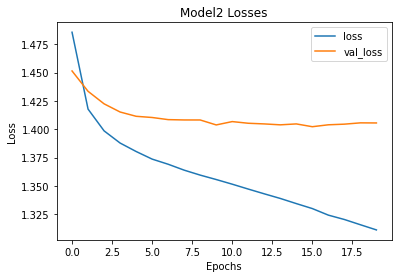

In [36]:
plt.figure(figsize=(10, 10))
losses2[['loss','val_loss']].plot()
plt.title('Model2 Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss');

<Figure size 720x720 with 0 Axes>

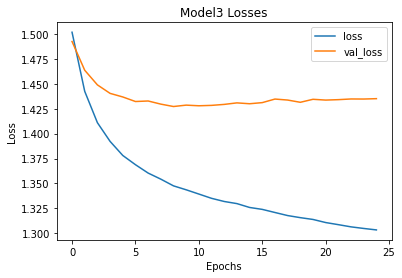

In [37]:
plt.figure(figsize=(10, 10))
losses3[['loss','val_loss']].plot()
plt.title('Model3 Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss');

# Step 6: Predictions

In [38]:
validation_examples.head(10)

,Gender_Female,Gender_Male,Fever_Absent,Fever_Present,Nausea/Vomting_Absent,Nausea/Vomting_Present,Headache _Absent,Headache _Present,Diarrhea _Absent,Diarrhea _Present,Fatigue & generalized bone ache _Absent,Fatigue & generalized bone ache _Present,Jaundice _Absent,Jaundice _Present,Epigastric pain _Absent,Epigastric pain _Present,Age,BMI,WBC,RBC,HGB,Plat,AST 1,ALT 1,RNA Base
496,-0.98,0.98,1.03,-1.03,1.01,-1.01,-1.01,1.01,1.02,-1.02,1.02,-1.02,-1.01,1.01,-1.00,1.00,-1.07,0.59,1.53,0.31,-0.35,-1.47,-0.54,0.08,-0.29
1144,1.02,-1.02,1.03,-1.03,1.01,-1.01,0.99,-0.99,-0.98,0.98,-0.98,0.98,0.99,-0.99,1.00,-1.00,1.54,0.34,0.21,0.88,1.40,-0.30,-1.42,1.50,-1.41
575,-0.98,0.98,1.03,-1.03,1.01,-1.01,-1.01,1.01,1.02,-1.02,-0.98,0.98,0.99,-0.99,-1.00,1.00,-0.95,-0.15,-1.61,-0.43,-0.35,-1.54,0.89,1.24,-1.11
705,1.02,-1.02,-0.97,0.97,-0.99,0.99,-1.01,1.01,-0.98,0.98,-0.98,0.98,-1.01,1.01,-1.00,1.00,0.29,-1.61,-1.18,0.10,0.82,-1.23,-0.34,-0.77,-1.57
530,1.02,-1.02,-0.97,0.97,-0.99,0.99,-1.01,1.01,1.02,-1.02,1.02,-1.02,-1.01,1.01,1.00,-1.00,1.43,-0.88,-1.32,1.27,-0.35,-1.14,-1.07,1.08,0.03
375,-0.98,0.98,1.03,-1.03,-0.99,0.99,-1.01,1.01,-0.98,0.98,1.02,-1.02,-1.01,1.01,-1.00,1.00,-0.27,0.34,-1.29,1.57,-0.93,1.06,-0.46,0.12,1.25
654,1.02,-1.02,-0.97,0.97,1.01,-1.01,0.99,-0.99,1.02,-1.02,-0.98,0.98,-1.01,1.01,-1.00,1.00,1.65,1.32,0.77,-0.92,-1.51,1.74,0.12,-0.50,-1.48
1064,1.02,-1.02,1.03,-1.03,-0.99,0.99,-1.01,1.01,1.02,-1.02,-0.98,0.98,0.99,-0.99,1.00,-1.00,1.43,-1.37,0.52,0.61,0.82,1.56,1.04,0.54,-1.24
193,1.02,-1.02,-0.97,0.97,-0.99,0.99,0.99,-0.99,1.02,-1.02,1.02,-1.02,-1.01,1.01,1.00,-1.00,0.07,1.08,-0.85,1.48,-0.93,0.45,-1.65,0.08,-0.15
1341,1.02,-1.02,1.03,-1.03,1.01,-1.01,-1.01,1.01,1.02,-1.02,-0.98,0.98,0.99,-0.99,-1.00,1.00,1.20,0.34,-1.07,1.47,-0.93,0.85,-0.34,-0.65,-0.27


In [39]:
np.argmax(model1.predict([list(validation_examples.loc[496,:])]), axis=1)

array([0])

In [40]:
validation_examples.loc[496,:]

Gender_Female           -0.98
Gender_Male              0.98
Fever_Absent             1.03
Fever_Present           -1.03
Nausea/Vomting_Absent    1.01
                         ... 
HGB                     -0.35
Plat                    -1.47
AST 1                   -0.54
ALT 1                    0.08
RNA Base                -0.29
Name: 496, Length: 25, dtype: float64

In [43]:
import joblib
model1.save("liver_disease_model.h5")
joblib.dump(scaler,'liver_disease_scaler.pkl')

['liver_disease_scaler.pkl']